In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime

CMAP = "Blues"

# Coastal Erosion Notebook

# Under Development

## Summary
This notebook takes advantage of a time series of Landsat-8 to produce an annual coastline product. 

## Overview
This product is produced, by loading in Landsat-8 data on an annual basis. For each scene a wofs product is produced to identify pixels containing water, as well as cloud and shadows masked. (This step could be replaced in further iterations by using pre-loaded wofs products to increase the computatoinal efficiency). Each scene is matched with it's equivalent tidal height and filtered images within a certain tidal range. Summary annual products are then produced, then shorelines extracted. 

This notebook takes advantage of DASK.

## Install requirements

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

## Import Required DC utils

In [3]:
# import required datacube modules
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
import datacube_utilities.waterline_functions_deaafrica as waterline_funcs
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createAOI import create_lat_lon
import glob
import datacube
import pandas as pd
from pandas import DataFrame
dc = datacube.Datacube(app='wofs dask')

In [4]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')

### Set Variables

In [5]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"

aoi_wkt = "POLYGON((178.67520332337 -18.046588897702, 178.68601799012 -18.046588897702, 178.68610382081 -18.057231903073, 178.67537498475 -18.05740356445, 178.67520332337 -18.046588897702))"
#aoi_wkt = "POLYGON((178.68713378906 -17.997493743896, 178.69846343994 -18.00624847412, 178.68301391601 -18.024959564208, 178.67288589477 -18.017063140868, 178.67305755615 -18.017063140868, 178.68713378906 -17.997493743896))"

time_range = ("2000", "2019")

tide_range = (0.00, 1.5)

time_step = '1Y'

#output_projection = "EPSG:32760"
output_projection = "EPSG:3460"
crs = "EPSG:3460"

res = (30)

In [6]:

tide_files = glob.glob("/home/jovyan/odc-hub/tides/*.csv")
print(tide_files)

['/home/jovyan/odc-hub/tides/IDO70004_2004.csv', '/home/jovyan/odc-hub/tides/IDO70004_2012.csv', '/home/jovyan/odc-hub/tides/IDO70004_2010.csv', '/home/jovyan/odc-hub/tides/IDO70004_2015.csv', '/home/jovyan/odc-hub/tides/IDO70004_1995.csv', '/home/jovyan/odc-hub/tides/IDO70004_2013.csv', '/home/jovyan/odc-hub/tides/IDO70004_1996.csv', '/home/jovyan/odc-hub/tides/IDO70004_2006.csv', '/home/jovyan/odc-hub/tides/IDO70004_2001.csv', '/home/jovyan/odc-hub/tides/IDO70004_2000.csv', '/home/jovyan/odc-hub/tides/IDO70004_2017.csv', '/home/jovyan/odc-hub/tides/IDO70004_1998.csv', '/home/jovyan/odc-hub/tides/IDO70004_2016.csv', '/home/jovyan/odc-hub/tides/IDO70004_2009.csv', '/home/jovyan/odc-hub/tides/IDO70004_1993.csv', '/home/jovyan/odc-hub/tides/IDO70004_2002.csv', '/home/jovyan/odc-hub/tides/IDO70004_1992.csv', '/home/jovyan/odc-hub/tides/IDO70004_1994.csv', '/home/jovyan/odc-hub/tides/IDO70004_1997.csv', '/home/jovyan/odc-hub/tides/IDO70004_2011.csv', '/home/jovyan/odc-hub/tides/IDO70004_20

### Create AOI

In [7]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [8]:
waterline_funcs.display_map(latitude=lat_extents, longitude=lon_extents)

In [9]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [10]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [11]:
%%time
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

CPU times: user 168 ms, sys: 3.92 ms, total: 172 ms
Wall time: 171 ms


In [12]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [13]:
#create resolution
resolution = (-res, res)

In [14]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

### Import Landsat-8 data

In [15]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks,
    'crs': crs,
}

#Import L8 scenes for the given period
scenes = dc.load(product="ls8_water_classification",
                 group_by='solar_day',
                 measurements = ['water_classification'],
                 **query
)

# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'y': lat_extents,
    'x': lon_extents,
    'time': time_range,
    'resolution': resolution,
    'output_crs': output_projection,  
}


In [16]:
def load_ard(dc,
             products=None,
             min_gooddata=0.0,
             fmask_gooddata=[1, 4, 5],
             mask_pixel_quality=True,
             mask_invalid_data=True,
             mask_contiguity='nbart_contiguity',
             mask_dtype=np.float32,
             ls7_slc_off=True,
             product_metadata=False,
             **dcload_kwargs):
    '''
    Loads Landsat Collection 3 or Sentinel 2 Definitive and Near Real 
    Time data for multiple sensors (i.e. ls5t, ls7e and ls8c for 
    Landsat; s2a and s2b for Sentinel 2), and returns a single masked 
    xarray dataset containing only observations that contain greater 
    than a given proportion of good quality pixels. This can be used 
    to extract clean time series of observations that are not affected 
    by cloud, for example as an input to the `animated_timeseries` 
    function from `dea_plotting`.
    
    The proportion of good quality pixels is calculated by summing the 
    pixels flagged as good quality in `fmask`. By default non-cloudy or 
    shadowed land, snow and water pixels are treated as good quality, 
    but this can be customised using the `fmask_gooddata` parameter.
    
    Last modified: February 2020
    
    Parameters
    ----------  
    dc : datacube Datacube object
        The Datacube to connect to, i.e. `dc = datacube.Datacube()`.
        This allows you to also use development datacubes if required.    
    products : list
        A list of product names to load data from. Valid options are 
        ['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] for Landsat,
        ['s2a_ard_granule', 's2b_ard_granule'] for Sentinel 2 Definitive, 
        and ['s2a_nrt_granule', 's2b_nrt_granule'] for Sentinel 2 Near 
        Real Time (on the DEA Sandbox only).
    min_gooddata : float, optional
        An optional float giving the minimum percentage of good quality 
        pixels required for a satellite observation to be loaded. 
        Defaults to 0.0 which will return all observations regardless of
        pixel quality (set to e.g. 0.99 to return only observations with
        more than 99% good quality pixels).
    fmask_gooddata : list, optional
        An optional list of fmask values to treat as good quality 
        observations in the above `min_gooddata` calculation. The 
        default is `[1, 4, 5]` which will return non-cloudy or shadowed 
        land, snow and water pixels. Choose from: 
        `{'0': 'nodata', '1': 'valid', '2': 'cloud', 
          '3': 'shadow', '4': 'snow', '5': 'water'}`.
    mask_pixel_quality : bool, optional
        An optional boolean indicating whether to apply the good data 
        mask to all observations that were not filtered out for having 
        less good quality pixels than `min_gooddata`. E.g. if 
        `min_gooddata=0.99`, the filtered observations may still contain 
        up to 1% poor quality pixels. The default of False simply 
        returns the resulting observations without masking out these 
        pixels; True masks them and sets them to NaN using the good data 
        mask. This will convert numeric values to floating point values 
        which can cause memory issues, set to False to prevent this.
    mask_invalid_data : bool, optional
        An optional boolean indicating whether invalid -999 nodata 
        values should be replaced with NaN. These invalid values can be
        caused by missing data along the edges of scenes, or terrain 
        effects (for NBART). Be aware that masking out invalid values 
        will convert all numeric values to floating point values when 
        -999 values are replaced with NaN, which can cause memory issues.
    mask_contiguity : str or bool, optional
        An optional string or boolean indicating whether to mask out 
        pixels missing data in any band (i.e. "non-contiguous" values). 
        Although most missing data issues are resolved by 
        `mask_invalid_data`, this step is important for generating 
        clean and concistent composite datasets. The default
        is `mask_contiguity='nbart_contiguity'` which will set any 
        pixels with non-contiguous values to NaN based on NBART data. 
        If you are loading NBAR data instead, you should specify
        `mask_contiguity='nbar_contiguity'` instead. To ignore non-
        contiguous values completely, set `mask_contiguity=False`.
        Be aware that masking out non-contiguous values will convert 
        all numeric values to floating point values when -999 values 
        are replaced with NaN, which can cause memory issues.
    mask_dtype : numpy dtype, optional
        An optional parameter that controls the data type/dtype that
        layers are coerced to when when `mask_pixel_quality=True` or 
        `mask_contiguity=True`. Defaults to `np.float32`, which uses
        approximately 1/2 the memory of `np.float64`.
    ls7_slc_off : bool, optional
        An optional boolean indicating whether to include data from 
        after the Landsat 7 SLC failure (i.e. SLC-off). Defaults to 
        True, which keeps all Landsat 7 observations > May 31 2003. 
    product_metadata : bool, optional
        An optional boolean indicating whether to return the dataset 
        with a `product` variable that gives the name of the product 
        that each observation in the time series came from (e.g. 
        'ga_ls5t_ard_3'). Defaults to False.
    **dcload_kwargs : 
        A set of keyword arguments to `dc.load` that define the 
        spatiotemporal query used to extract data. This typically
        includes `measurements`, `x`, `y`, `time`, `resolution`, 
        `resampling`, `group_by` and `crs`. Keyword arguments can 
        either be listed directly in the `load_ard` call like any 
        other parameter (e.g. `measurements=['nbart_red']`), or by 
        passing in a query kwarg dictionary (e.g. `**query`). For a 
        list of possible options, see the `dc.load` documentation: 
        https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html          
        
    Returns
    -------
    combined_ds : xarray Dataset
        An xarray dataset containing only satellite observations that 
        contains greater than `min_gooddata` proportion of good quality 
        pixels.   
        
    '''
    
    # Due to possible bug in xarray 0.13.0, define temporary function 
    # which converts dtypes in a way that preserves attributes
    def astype_attrs(da, dtype=np.float32):
        '''
        Loop through all data variables in the dataset, record 
        attributes, convert to a custom dtype, then reassign attributes. 
        If the data variable cannot be converted to the custom dtype 
        (e.g. trying to convert non-numeric dtype like strings to 
        floats), skip and return the variable unchanged.
        
        This can be combined with `.where()` to save memory. By casting 
        to e.g. np.float32, we prevent `.where()` from automatically 
        casting to np.float64, using 2x the memory. np.float16 could be 
        used to save even more memory (although this may not be 
        compatible with all downstream applications).
        
        This custom function is required instead of using xarray's 
        built-in `.astype()`, due to a bug in xarray 0.13.0 that drops
        attributes: https://github.com/pydata/xarray/issues/3348
        '''
        
        try:            
            da_attr = da.attrs
            da = da.astype(dtype)
            da = da.assign_attrs(**da_attr)
            return da
        
        except ValueError:        
            return da         
    dcload_kwargs = deepcopy(dcload_kwargs)  
    
    # Determine if lazy loading is required
    lazy_load = 'dask_chunks' in dcload_kwargs
    
    # Warn user if they combine lazy load with min_gooddata
    if (min_gooddata > 0.0) & lazy_load:
                warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "
                              "will cause dask arrays to compute when "
                              "loading pixel-quality data to calculate "
                              "'good pixel' percentage. This can "
                              "significantly slow the return of your dataset.")
    
    # Verify that products were provided, and that only Sentinel-2 or 
    # only Landsat products are being loaded at the same time
    if not products:
        raise ValueError("Please provide a list of product names "
                         "to load data from. Valid options are: \n"
                         "['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] " 
                         "for Landsat, ['s2a_ard_granule', "
                         "'s2b_ard_granule'] \nfor Sentinel 2 Definitive, or "
                         "['s2a_nrt_granule', 's2b_nrt_granule'] for "
                         "Sentinel 2 Near Real Time")
    elif all(['ls' in product for product in products]):
        product_type = 'ls'
    elif all(['s2' in product for product in products]):
        product_type = 's2'
    else:
        raise ValueError("Loading both Sentinel-2 and Landsat data "
                         "at the same time is currently not supported")

    # Create a list to hold data for each product
    product_data = []

    # Iterate through each requested product
    for product in products:

        try:

            # Load data including fmask band
            print(f'Loading {product} data')
            try:
                
                # If dask_chunks is specified, load data using query
                if lazy_load:
                    ds = dc.load(product=f'{product}',
                                 **dcload_kwargs)
                
                # If no dask chunks specified, add this param so that
                # we can lazy load data before filtering by good data
                else:
                    ds = dc.load(product=f'{product}',
                                 dask_chunks={},
                                 **dcload_kwargs) 
                
            except KeyError as e:
                raise ValueError(f'Band {e} does not exist in this product. '
                                 f'Verify all requested `measurements` exist '
                                 f'in {products}')
            
            # Keep a record of the original number of observations
            total_obs = len(ds.time)
            print(total_obs)
            
            # Identify all pixels not affected by cloud/shadow/invalid
            good_quality = ds
                
            # If any data was returned
            if len(ds.time) > 0:

                # Optionally apply pixel quality mask to observations 
                # remaining after the filtering step above to mask out 
                # all remaining bad quality pixels
                if mask_pixel_quality:
                    print('    Applying pixel quality/cloud mask')

                    # Change dtype to custom float before masking to 
                    # save memory. See `astype_attrs` func docstring 
                    # above for details  
                    ds = ds.apply(astype_attrs, 
                                  dtype=mask_dtype, 
                                  keep_attrs=True)
                    ds = ds.where(good_quality)
                    
                # Optionally filter to replace no data values with nans
                if mask_invalid_data:
                    print('    Applying invalid data mask')

                    # Change dtype to custom float before masking to 
                    # save memory. See `astype_attrs` func docstring 
                    # above for details           
                    ds = ds.apply(astype_attrs, 
                                  dtype=mask_dtype, 
                                  keep_attrs=True)
                    ds = masking.mask_invalid_data(ds)

                # If any data was returned, add result to list
                product_data.append(ds)
               
            # If no data is returned, print status
            else:
                print(f'    No data for {product}')
                

            # If  AttributeError due to there being no variables in
            # the dataset, skip this product and move on to the next
        except AttributeError:
            print(f'    No data for {product}')
               # If any data was returned above, combine into one xarray
    if (len(product_data) > 0):
        # Concatenate results and sort by time
        print(f'Combining and sorting data')
        combined_ds = xr.concat(product_data, dim='time').sortby('time')
        
        # If `lazy_load` is True, return data as a dask array without
        # actually loading it in
        if lazy_load:
            print(f'    Returning {len(combined_ds.time)} observations'' as a dask array')
            return combined_ds
        else:
            print(f'    Returning {len(combined_ds.time)} observations ')
            return combined_ds.compute()

            # If no data was returned:
    else:
        print('No data returned for query')
        return None

In [17]:
from copy import deepcopy

In [18]:
# load in the tide data. Edit this to make sure you have data that overlaps with what you are working on.
# the data here comes from http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml for fiji

In [19]:
# Load available data from all three Landsat satellites
#from datacube_utilities.dea_datahandling import load_ard
landsat_ds = load_ard(dc=dc,
                      products=['ls8_water_classification', 
                                'ls7_water_classification',
                                'ls5_water_classification',
                                'ls4_water_classification'],
                      group_by='solar_day',
                      mask_invalid_data=False,
                      mask_pixel_quality=False,
                      **query)

Loading ls8_water_classification data
145
Loading ls7_water_classification data
176
Loading ls5_water_classification data
    No data for ls5_water_classification
Loading ls4_water_classification data
    No data for ls4_water_classification
Combining and sorting data
    Returning 321 observations as a dask array


In [20]:
#water_classes.isel(time = 4).water_classification.plot();
water_classes = dask.delayed(landsat_ds.where(landsat_ds >= 0))

In [21]:
water_classes_comp = water_classes.compute()

In [22]:
%%time
# Do we need to use dask for this?
dfs = []
# the data here comes from http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml for fij
for f in tide_files:


    # We must read the data now because it doesn't exist on the dask workers
    df = pd.read_csv(f)
    print(df.shape)
    if 'Sea Level' in df.columns: 
        df['tides'] = df['Sea Level']
        df = pd.DataFrame.drop(df, columns=['Sea Level'])
    elif 'tide' in df.columns:
        df['tides'] = df['tide']
        df = pd.DataFrame.drop(df, columns=['tide'])
    else: 
        print('variables correct')
        #df2 = df
    if ' Date & UTC Time' in df.columns:
        df['time'] = df[' Date & UTC Time']
        df = pd.DataFrame.drop(df, columns=[' Date & UTC Time'])
    else:
        print('variable2 correct')
    #print(df['time'])
    
    dfs.append(df)

tide_data = pd.concat(dfs)
print(tide_data.shape)    
tide_data['time'] = pd.to_datetime(tide_data['time'], infer_datetime_format=False)
print(tide_data.shape)    

(8784, 12)
(8784, 12)
(8760, 12)
(8760, 12)
variable2 correct
(8760, 12)
(8760, 12)
variable2 correct
(8784, 12)
(8760, 12)
(8760, 12)
(8784, 12)
(8760, 12)
variable2 correct
(8760, 12)
(8784, 12)
variable2 correct
(8760, 12)
(8760, 12)
(8760, 12)
(2208, 12)
(8760, 12)
(8760, 12)
(8760, 12)
(8760, 12)
(8784, 12)
(8760, 12)
(8760, 12)
(8760, 12)
variable2 correct
(8760, 12)
(8760, 12)
variable2 correct
(8760, 12)
(238872, 13)
(238872, 13)
CPU times: user 52.1 s, sys: 164 ms, total: 52.2 s
Wall time: 53.8 s


In [23]:
print(tide_data.head(1))

    Fiji  Adjusted Residuals  Air Temperature  Barometric Pressure  Fiji  \
0    NaN              -0.093             29.0               1001.8   NaN   

   Lautoka  Residuals  Water Temperature  Wind Direction  Wind Gust  \
0      NaN      0.023               30.1             284        3.9   

   Wind Speed  tides       time  
0         2.0  1.628 2004-01-01  


### Import tide height data 
Into pandas and concatenate each year together.

Shoreline location varies with tides, only tide heights at specific conditions are kept - determined by tide_range setting. If tide_range values at 0.00, 2.00 then only tides between 0 and 2m relative to Mean Sea Level are kept. 

In [24]:
tide_data['tide_height'] = tide_data['tides']
new = tide_data.set_index('time')
df4 = new.loc[~new.index.duplicated(keep='first')]
print(df4.shape)
df5 = df4[df4.tides != -9999]
print(df5.shape)

(238872, 13)
(236088, 13)


<xarray.Dataset>
Dimensions:      (time: 321, x: 39, y: 41)
Coordinates:
  * y            (y) float64 3.884e+06 3.884e+06 ... 3.883e+06 3.883e+06
  * x            (x) float64 1.992e+06 1.992e+06 ... 1.993e+06 1.993e+06
  * time         (time) datetime64[ns] 2000-02-02 ... 2019-09-10T22:06:52
Data variables:
    water        (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan
    tide_height  (time) float64 1.056 1.47 1.226 0.728 ... 0.76 0.7443 0.6041
Attributes:
    crs:      EPSG:3460


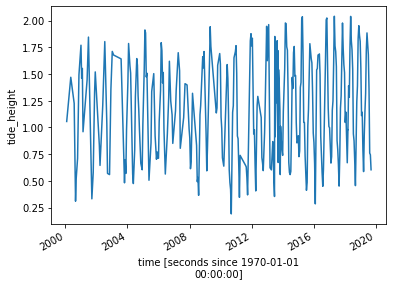

In [25]:
# First, we convert the data to an xarray dataset so we can analyse it in the same way as our Landsat data
tide_data_xr = df5.to_xarray()
# We want to convert our hourly tide heights to estimates of exactly how high the tide was at the time that
# each satellite image was taken. To do this, we can use `.interp` to 'interpolate' a tide height for each
# Landsat timestamp:
landsat_tideheights = tide_data_xr.interp(time=water_classes_comp.time)

# We then want to put these values back into the Landsat dataset so that each image has an estimated tide height:
water_classes_comp['tide_height'] = landsat_tideheights.tide_height
print((water_classes_comp))
# Plot the resulting tide heights for each Landsat image:
water_classes_comp.tide_height.plot()

plt.show()

### Filter Landsat Images by tide height

Only keep the Landsat Images which correspond to the desired tide height.

In [26]:
landsat_hightide = water_classes_comp.where((water_classes_comp.tide_height > tide_range[0]) & 
                                   (water_classes_comp.tide_height < tide_range[1]), drop=True)

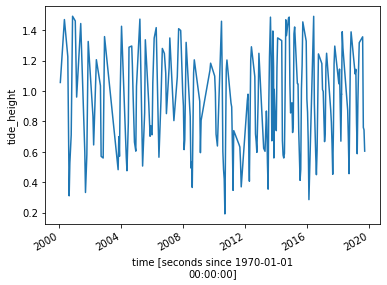

In [27]:
# Plot the resulting tide heights for each Landsat image:
landsat_hightide.tide_height.plot()
plt.show()

### Create Summary Images of Water.

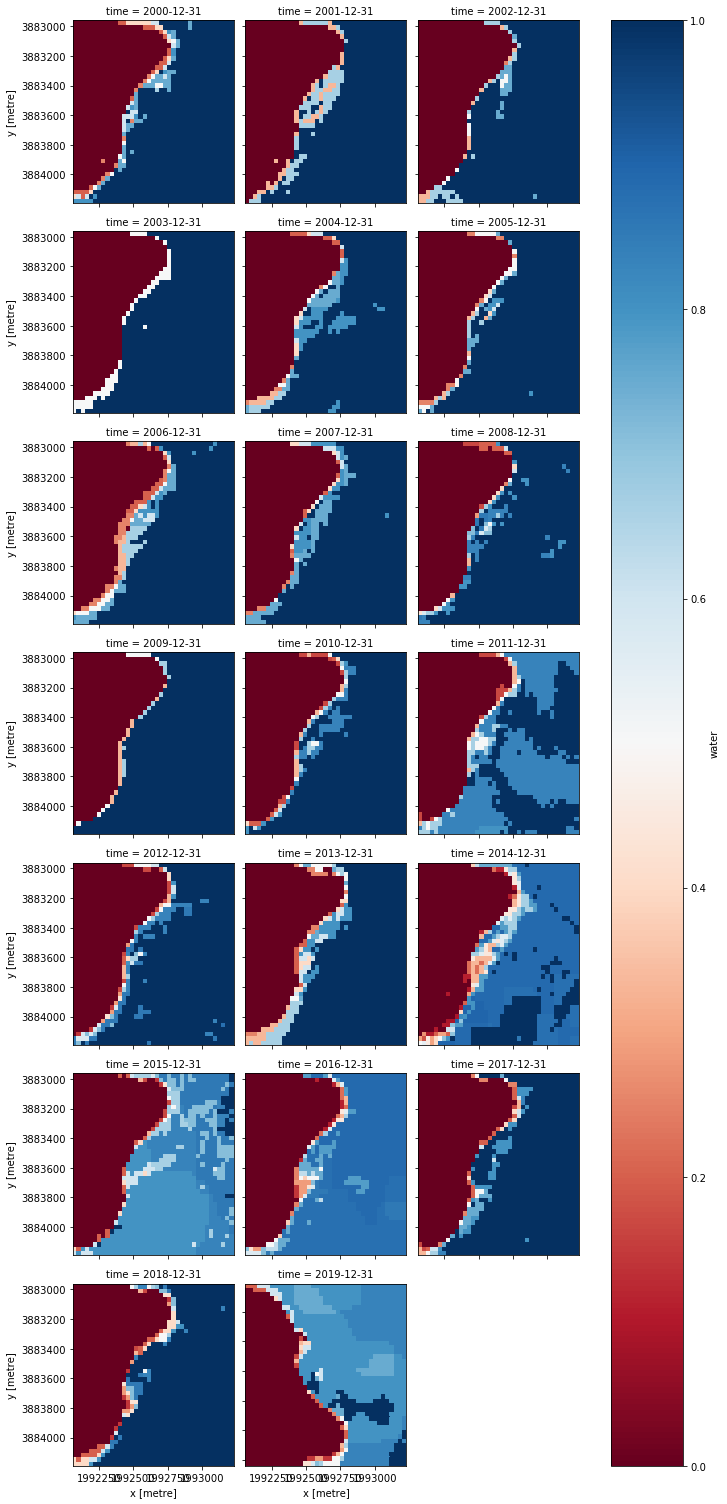

In [28]:
landsat_resampled = landsat_hightide.water.compute().resample(time=time_step).mean('time')
landsat_resampled.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

### Extract Shorelines from Imagery

Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
    Extracting contour 2
    Extracting contour 3
    Extracting contour 4
    Extracting contour 5
    Extracting contour 6
    Extracting contour 7
    Extracting contour 8
    Extracting contour 9
    Extracting contour 10
    Extracting contour 11
    Extracting contour 12
    Extracting contour 13
    Extracting contour 14
    Extracting contour 15
    Extracting contour 16
    Extracting contour 17
    Extracting contour 18
    Extracting contour 19
Exporting contour shapefile to output_waterlines.shp


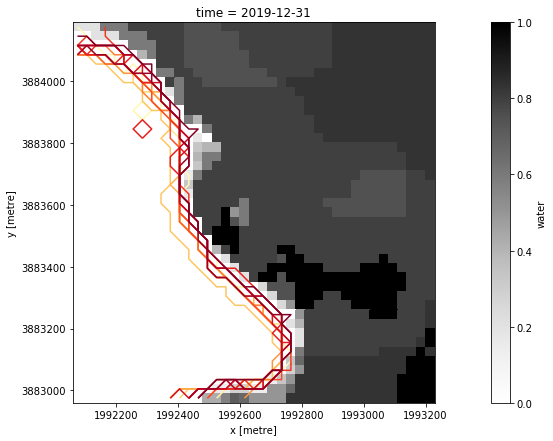

In [29]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in landsat_resampled.time.values]}
attribute_dtypes = {'time': 'str'}

contour_gdf = waterline_funcs.contour_extract(
    z_values=[0],
    ds_array=landsat_resampled,
    ds_crs=landsat_ds.crs,
    ds_affine=landsat_ds.geobox.transform,
    output_shp=f'output_waterlines.shp',
    attribute_data=attribute_data,
    attribute_dtypes=attribute_dtypes,
    min_vertices=5
)

# Plot output shapefile over the top of the first year's MNDWI layer
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
landsat_resampled.isel(time=-1).plot(ax=ax, cmap='Greys', alpha=1.0, edgecolors=None)
contour_gdf.plot(cmap='YlOrRd', ax=ax)


### Plot Interactive map of output shorelines coloured by time

In [30]:
waterline_funcs.map_shapefile(gdf=contour_gdf)

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

In [31]:
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB
